In [1]:
import torch
from torch import nn
from datasets import load_dataset
import fastcore.all as fc
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, default_collate
from torch import optim

In [2]:
import matplotlib.pyplot as plt

In [45]:
name = 'fashion_mnist'
x,y = 'image','label'
dsr = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00, 117.99it/s]


In [46]:
def transform(b):
    b[x] = [TF.to_tensor(ele)-0.5 for ele in b[x]]
    return b

In [47]:
dst = dsr.with_transform(transform)

In [48]:
def collate_dict(b):
     clt = default_collate(b)
     return (clt[x], clt[y])

class DataLoaders:
     def __init__(self, train_ds, valid_ds, batch_size, collate_fn, **kwargs):
          self.train = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, **kwargs)
          self.valid = DataLoader(valid_ds, batch_size=batch_size*2, collate_fn=collate_fn, shuffle=True, **kwargs)

In [49]:
bs = 1024
dls = DataLoaders(dst['train'], dst['test'], batch_size=bs, collate_fn=collate_dict)

In [50]:
xb,yb = next(iter(dls.train))
xb.shape, yb.shape, xb.min(), xb.max()

(torch.Size([1024, 1, 28, 28]),
 torch.Size([1024]),
 tensor(-0.5000),
 tensor(0.5000))

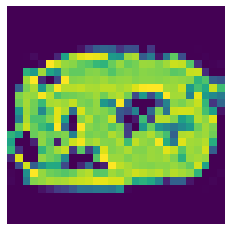

In [58]:
plt.imshow(xb[2].permute(1, 2, 0));
plt.axis('off');

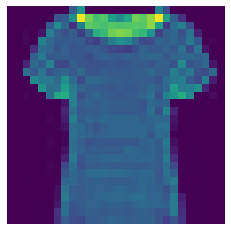

In [62]:
plt.imshow(xb[5].permute(1, 2, 0));
plt.axis('off');

In [63]:
def conv(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=s, padding=ks//2, bias=bias)]
    if norm is not None:
        layers.append(norm)
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
    return nn.Sequential(
        conv(ni, nf, ks=ks, s=1, act=act, bias=bias),
        conv(nf, nf, s=s, norm=norm, act=None, bias=bias)
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
        super().__init__()
        self.conv = _conv_block(ni, nf, ks=ks, s=s, act=act, norm=norm, bias=bias)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, s=1, ks=1, act=None)
        self.pool = nn.noop if s==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.conv(x) + self.idconv(self.pool(x)))

In [64]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cls = self._cls()
    
    def _cls(self):
        return nn.Sequential(
        ResBlock(1, 8, norm=nn.LayerNorm([8, 14, 14])),
        ResBlock(8, 16, norm=nn.LayerNorm([16, 7, 7])),
        ResBlock(16, 32, norm=nn.LayerNorm([32, 4, 4])),
        ResBlock(32, 64, norm=nn.LayerNorm([64, 2, 2])),
        ResBlock(64, 64,  norm=nn.LayerNorm([64, 1, 1])),
        conv(64, 10, act=False),
        nn.Flatten(),
    )
    
    def forward(self, x):
        return self.cls(x)

In [12]:
model = Classifier()
model(xb).shape

torch.Size([1024, 10])

In [65]:
def kaiming_init(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        nn.init.kaiming_normal_(m.weight)

In [ ]:
epochs = 5
lr = 0.01
max_lr = 0.2
model = Classifier()
model.apply(kaiming_init)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr, total_steps=len(dls.train), epochs=epochs)
for epoch in range(epochs):
    for train in (True, False):
        dl = dls.train if train else dls.valid
        accuracy = 0
        for xb,yb in dl:
            pred = model(xb)
            loss = F.cross_entropy(pred, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (pred.argmax(dim=1) == yb).float().mean()
        accuracy /= len(dl)
        if train:
            sched.step()
        print(f"train: {'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}, accuracy:{accuracy:.4f}")

In [88]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.view(self.dim)

class RTanh(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        x = nn.Tanh()(x)
        return 0.5*x 

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = self._encoder()
        self.decoder = self._decoder()
    
    def _encoder(self):
        return nn.Sequential(
            Reshape((-1, 28*28)),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
    
    def _decoder(self):
        return nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            RTanh(),
            Reshape((-1, 1, 28, 28))
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [89]:
model = AutoEncoder()
output = model(xb).detach().cpu()
output.shape
xb.min(),xb.max()

(tensor(-0.5000), tensor(0.5000))

In [95]:
epochs = 40
lr = 1e-3
max_lr = 0.2
model = AutoEncoder()
model.apply(kaiming_init)
opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr, total_steps=len(dls.train), epochs=epochs)
for epoch in range(epochs):
    for train in (True, False):
        dl = dls.train if train else dls.valid
        accuracy = 0
        for xb,yb in dl:
            pred = model(xb)
            loss = F.mse_loss(pred, xb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
        # if train:
        #     sched.step()
        print(f"train: {'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}")

train: train, epoch:1, loss: 0.0434
train: eval, epoch:1, loss: 0.0400
train: train, epoch:2, loss: 0.0316
train: eval, epoch:2, loss: 0.0305
train: train, epoch:3, loss: 0.0253
train: eval, epoch:3, loss: 0.0252
train: train, epoch:4, loss: 0.0225
train: eval, epoch:4, loss: 0.0240
train: train, epoch:5, loss: 0.0215
train: eval, epoch:5, loss: 0.0219
train: train, epoch:6, loss: 0.0202
train: eval, epoch:6, loss: 0.0206
train: train, epoch:7, loss: 0.0197
train: eval, epoch:7, loss: 0.0197
train: train, epoch:8, loss: 0.0184
train: eval, epoch:8, loss: 0.0190
train: train, epoch:9, loss: 0.0190
train: eval, epoch:9, loss: 0.0190
train: train, epoch:10, loss: 0.0174
train: eval, epoch:10, loss: 0.0185
train: train, epoch:11, loss: 0.0182
train: eval, epoch:11, loss: 0.0179
train: train, epoch:12, loss: 0.0177
train: eval, epoch:12, loss: 0.0174
train: train, epoch:13, loss: 0.0167
train: eval, epoch:13, loss: 0.0173
train: train, epoch:14, loss: 0.0164
train: eval, epoch:14, loss: 0.0

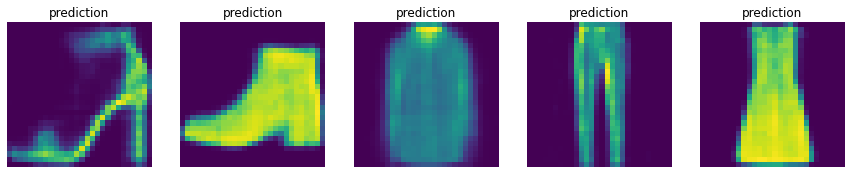

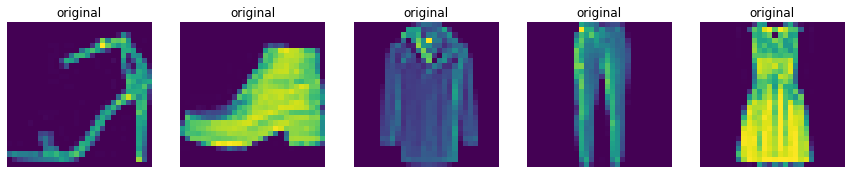

In [96]:
outp = model(xb).detach()
sz = 5
imgs = outp[:sz]
imgs.shape
_,axs = plt.subplots(1, sz, figsize=(15, 15))
for img, ax in zip(imgs, axs.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('prediction')

_,axs2 = plt.subplots(1, sz, figsize=(15, 15))
for img, ax in zip(xb[:sz], axs2.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('original')